# Predicting the gender of a voice

In [1]:
# Import libraries
import seaborn as sns
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## The data set

The data set used in this analysis was downloaded from _Kaggle_ and can be viewed here: [Gender Recognition by Voice](https://www.kaggle.com/primaryobjects/voicegender/home).

In [2]:
# Import data set
df = pd.read_csv("5_voice.csv")

df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


#### Variables explained

The following acoustic properties of each voice are measured and included in the csv:

* meanfreq: mean frequency (in kHz)
* sd: standard deviation of frequency
* median: median frequency (in kHz)
* Q25: first quantile (in kHz)
* Q75: third quantile (in kHz)
* IQR: interquantile range (in kHz)
* skew: skewness
* kurt: kurtosis
* sp.ent: spectral entropy
* sfm: spectral flatness
* mode: mode frequency
* centroid: frequency centroid
* peakf: peak frequency (frequency with highest energy)
* meanfun: average of fundamental frequency measured across acoustic signal
* minfun: minimum fundamental frequency measured across acoustic signal
* maxfun: maximum fundamental frequency measured across acoustic signal
* meandom: average of dominant frequency measured across acoustic signal
* mindom: minimum of dominant frequency measured across acoustic signal
* maxdom: maximum of dominant frequency measured across acoustic signal
* dfrange: range of dominant frequency measured across acoustic signal
* modindx: modulation index
* label: male or female

## Finding correlations

To be able to predict the y-variable _label_ (female / male), let's turn this categorical variable into a measurable dummy variable.

In [3]:
# Make dummies
dummies = pd.get_dummies(df["label"])
pd.get_dummies(df["label"])
df = pd.concat([df, dummies], axis=1)

df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label,female,male
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male,0,1
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male,0,1
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male,0,1
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male,0,1
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male,0,1


#### Correlation matrix

In [4]:
df.corr()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,female,male
meanfreq,1.000000,-0.739039,0.925445,0.911416,0.740997,-0.627605,-0.322327,-0.316036,-0.601203,-0.784332,...,0.460844,0.383937,0.274004,0.536666,0.229261,0.519528,0.515570,-0.216979,0.337415,-0.337415
sd,-0.739039,1.000000,-0.562603,-0.846931,-0.161076,0.874660,0.314597,0.346241,0.716620,0.838086,...,-0.466281,-0.345609,-0.129662,-0.482726,-0.357667,-0.482278,-0.475999,0.122660,-0.479539,0.479539
median,0.925445,-0.562603,1.000000,0.774922,0.731849,-0.477352,-0.257407,-0.243382,-0.502005,-0.661690,...,0.414909,0.337602,0.251328,0.455943,0.191169,0.438919,0.435621,-0.213298,0.283919,-0.283919
Q25,0.911416,-0.846931,0.774922,1.000000,0.477140,-0.874189,-0.319475,-0.350182,-0.648126,-0.766875,...,0.545035,0.320994,0.199841,0.467403,0.302255,0.459683,0.454394,-0.141377,0.511455,-0.511455
Q75,0.740997,-0.161076,0.731849,0.477140,1.000000,0.009636,-0.206339,-0.148881,-0.174905,-0.378198,...,0.155091,0.258002,0.285584,0.359181,-0.023750,0.335114,0.335648,-0.216475,-0.066906,0.066906
IQR,-0.627605,0.874660,-0.477352,-0.874189,0.009636,1.000000,0.249497,0.316185,0.640813,0.663601,...,-0.534462,-0.222680,-0.069588,-0.333362,-0.357037,-0.337877,-0.331563,0.041252,-0.618916,0.618916
skew,-0.322327,0.314597,-0.257407,-0.319475,-0.206339,0.249497,1.000000,0.977020,-0.195459,0.079694,...,-0.167668,-0.216954,-0.080861,-0.336848,-0.061608,-0.305651,-0.304640,-0.169325,-0.036627,0.036627
kurt,-0.316036,0.346241,-0.243382,-0.350182,-0.148881,0.316185,0.977020,1.000000,-0.127644,0.109884,...,-0.194560,-0.203201,-0.045667,-0.303234,-0.103313,-0.274500,-0.272729,-0.205539,-0.087195,0.087195
sp.ent,-0.601203,0.716620,-0.502005,-0.648126,-0.174905,0.640813,-0.195459,-0.127644,1.000000,0.866411,...,-0.513194,-0.305826,-0.120738,-0.293562,-0.294869,-0.324253,-0.319054,0.198074,-0.490552,0.490552
sfm,-0.784332,0.838086,-0.661690,-0.766875,-0.378198,0.663601,0.079694,0.109884,0.866411,1.000000,...,-0.421066,-0.362100,-0.192369,-0.428442,-0.289593,-0.436649,-0.431580,0.211477,-0.357499,0.357499


#### Findings

Most variables correlate with _label_. From strongest to weakest, the strongest correlations are:

* meanfun
* IQR
* Q25
* sp.ent
* sd
* sfm

Because these variables also correlate (strongly) with each other, let's be careful not to include too many x-variables in the predictive model and look for other (weaker) correlations.

For example, of the six strongest correlations, _sfm_ is the weakest and it correlates strongly with the other x-variables. Let's remove this variable from the selection.

Another example are the weaker correlations with _label_ that correlate strongly with each other like _dfrange_ and _maxdom_. These can't both be used in the model.

The optimal selection of x-variables is:

* meanfun (0.83)
* sd (-0.47)
* median (0.28)
* mindom (0.19)
* maxdom (0.19)

## Data analysis

In [5]:
df["label"].value_counts()

male      1584
female    1584
Name: label, dtype: int64

In the data, the number of men and women is equally divided. Let's predict if a voice is _female_.

In [6]:
# Make a subset
dfs = df[["meanfun", "sd", "median", "mindom", "maxdom", "female"]]

#### Scatter plot matrix

Before building the actual model, let's analyse the data visually and look for anomalies.

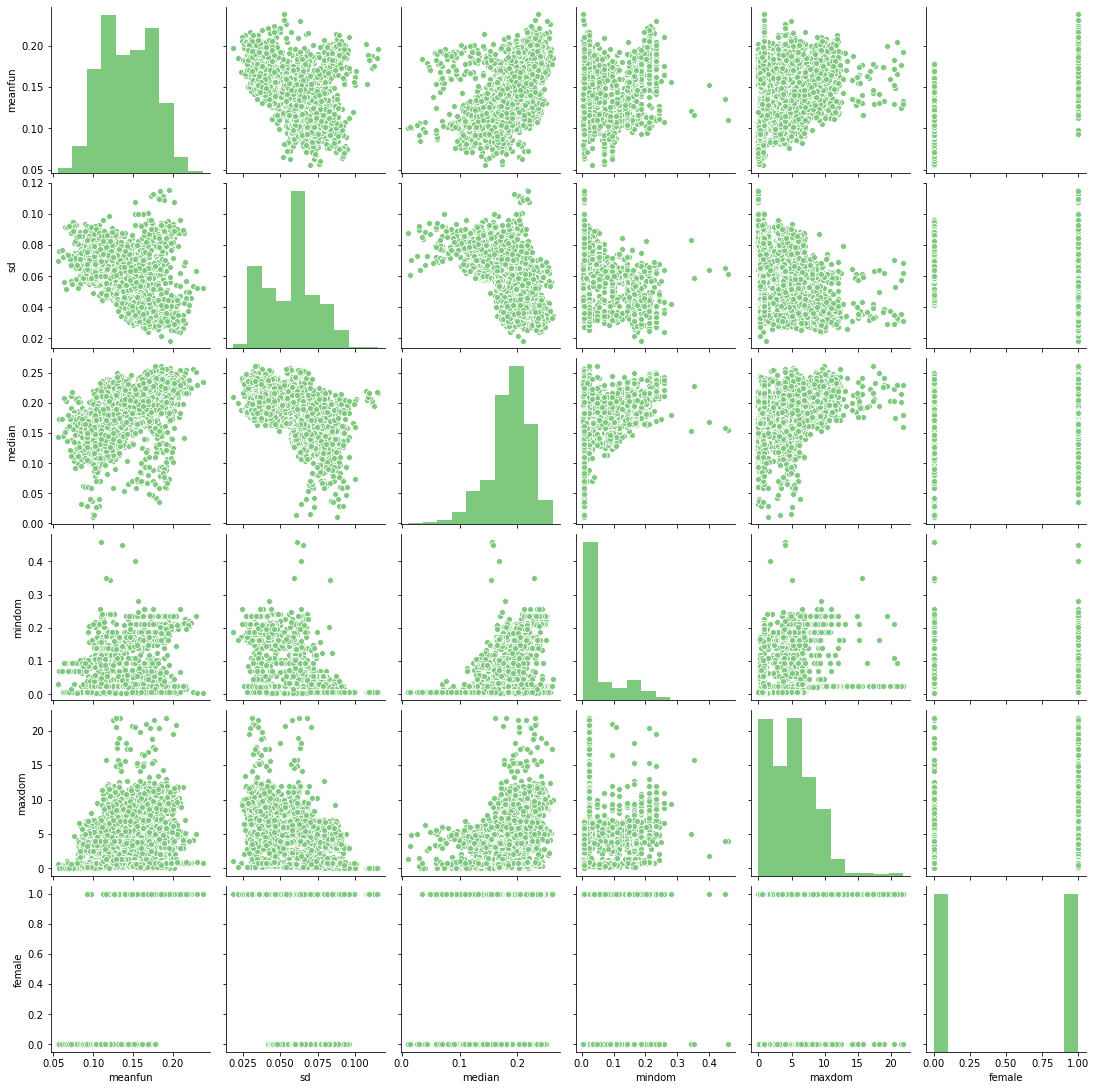

In [7]:
# Set palette for the plots
sns.set_palette(sns.color_palette("Accent"))

# Scatter plot matrix
sns.pairplot(dfs)
plt.show()

Since the scatter plots of the dummy variable _label_ don't tell us much, let's explore the data in a series of cat plots.

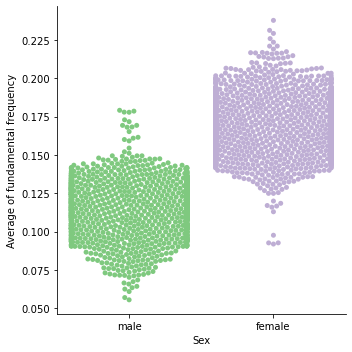

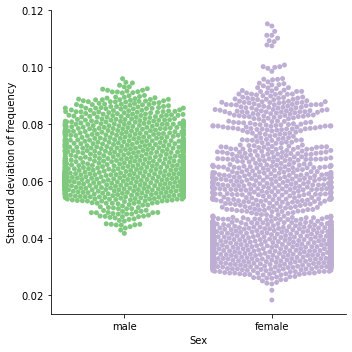

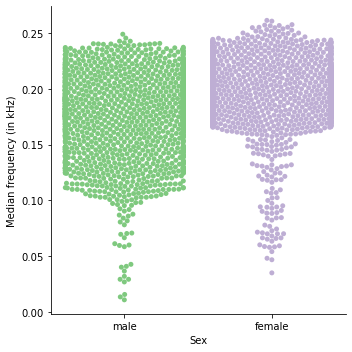

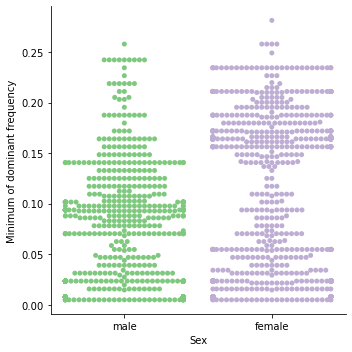

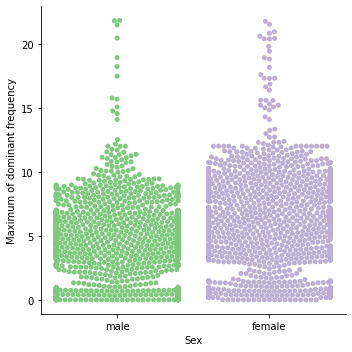

In [23]:
# Cat plots
sns.catplot(x="label", y="meanfun", kind="swarm", data=df)
plt.ylabel("Average of fundamental frequency")
plt.xlabel("Sex")
plt.show()

sns.catplot(x="label", y="sd", kind="swarm", data=df)
plt.ylabel("Standard deviation of frequency")
plt.xlabel("Sex")
plt.show()

sns.catplot(x="label", y="median", kind="swarm", data=df)
plt.ylabel("Median frequency (in kHz)")
plt.xlabel("Sex")
plt.show()

sns.catplot(x="label", y="mindom", kind="swarm", data=df)
plt.ylabel("Minimum of dominant frequency")
plt.xlabel("Sex")
plt.show()

sns.catplot(x="label", y="maxdom", kind="swarm", data=df)
plt.ylabel("Maximum of dominant frequency")
plt.xlabel("Sex")
plt.show()

#### Findings

The differences between female and male voices are clearly visible in the cat plots. For example, the strongest correlation with _label_ which is _meanfun_ is much higher for women than it is for men.

* A small number of voices with higher or lower values are pulling up (or down) the means of all cat plots
* Only _mindom_ has some improbable outliers above 0.3
* The rest of the data seems fine

In [9]:
# Remove outliers
df = df[df["mindom"] < 0.3]

# Make the final subset
dfs_final = df[["meanfun", "sd", "median", "mindom", "maxdom", "female"]]

## Random forest algorithm

Decision tree: based on a condition / internal node, the tree splits into branches. The end of the branch that doesn’t split anymore is the decision / leaf.

Random forest: an extension of decision tree. It consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest produces a class prediction and the class with the most votes becomes the model’s prediction.

#### _X_ and _y_

In [10]:
# Create a separate X and y
X = dfs_final.loc[:,"meanfun":"maxdom"]
y = dfs_final["female"]

X.head()

,meanfun,sd,median,mindom,maxdom
0,0.084279,0.064241,0.032027,0.007812,0.007812
1,0.107937,0.067310,0.040229,0.007812,0.054688
2,0.098706,0.083829,0.036718,0.007812,0.015625
3,0.088965,0.072111,0.158011,0.007812,0.562500
4,0.106398,0.079146,0.124656,0.007812,5.484375


#### Train and test set

In [11]:
# Randomly split the data into a 70% train set and a 30% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

X_train.head()

,meanfun,sd,median,mindom,maxdom
2955,0.162348,0.100239,0.202387,0.007812,0.007812
637,0.103187,0.081082,0.127906,0.007812,4.890625
722,0.092335,0.061142,0.135842,0.092773,0.815430
255,0.075519,0.089504,0.109826,0.007812,0.007812
2234,0.159553,0.068630,0.152600,0.023438,9.468750


#### Training the algorithm

In [12]:
rf = RandomForestClassifier(random_state=1, n_estimators=100)

# Fit the model
rf = rf.fit(X_train, y_train)

## Evaluating the model

#### Confusion matrix

In [13]:
# Predicted values
y_pred = rf.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

#  Create DataFrame and label it
cm = pd.DataFrame(cm, index=["not female (actual)", "female (actual)"], 
    columns = ["not female (pred)", "female (pred)"])
cm

,not female (pred),female (pred)
not female (actual),480,15
female (actual),7,447


From the confusion matrix we can conclude that:

* 480 voices are correctly predicted as _female_
* 447 voices are correctly predicted as _not female_
* 7 voices are wrongly predicted as _female_
* 15 voices are wrongly predicted as _not female_

#### Precision and recall

In [14]:
# Calculate precision and recall
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       495
           1       0.97      0.98      0.98       454

    accuracy                           0.98       949
   macro avg       0.98      0.98      0.98       949
weighted avg       0.98      0.98      0.98       949



_Precision_ for _female_ is very high (almost 1). Only about 3% of the suspected _female_ voices turn out to be _male_.

_Recall_ is high also. The model misses about 2% of _female_ voices.

#### $R^2$

In [15]:
# Calculate R^2
y_test_p = rf.predict(X_test)
r2_score(y_test, y_test_p)

0.9070974057758199

The $R^2$ is 0.90, meaning the model is accurate 90% of the times when predicting if a voice is _female_.

#### RMSE

In [16]:
# Calculate RMSE
math.sqrt(mean_squared_error(y_test, y_test_p))

0.1522573385912807

The _root mean squared error_ is 0.15, meaning the model is typically around 0.15 off when predicting if a voice is _female_.

#### Trying different parameters

In [25]:
rf_new  = RandomForestClassifier(n_estimators=250, random_state=1)
rf_new = rf_new.fit(X_train, y_train)
y_pred_new = rf_new.predict(X_test)

print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       495
           1       0.97      0.98      0.97       454

    accuracy                           0.98       949
   macro avg       0.98      0.98      0.98       949
weighted avg       0.98      0.98      0.98       949



Parameters that can be adjusted in the random forest algorithm:

* n_estimators = number of trees
* max_features = number of variables considered at each branch of a tree

Outcomes:

* adjusting the max_features is useless, since the _female_ / _male_ value can't be bigger than one
* sadly, adjusting the n_estimators hardly changes anything in the outcomes of _precision_ and _recall_